# Detection of kinks in curve fitting for scientific applications
## Introduction
*to-do: Introduce curve fitting and goodness of fit*
*to-do: Talk about currently applied verififications of goodness of fit*
*to-do: introduce concept of increasing complexity of equations to fit (ex. ReaxFF)*
*to-do: how this leads to kink formation when fitting curves to complex equations*

**When curve fitting complex equations using complex algorithms, kinks may appear in the final curve. Usually a visual inspection done by the user is required to accept or reject the fit if it is scientifically innacurate and does not reproduce correct natural behaviour (here, due to the presence of a kink). This document aims to provide a more automated and accurate method for detecting and rejecting fits presenting kinks.**

*to-do: explain advantages and disadvantages (easy sifting through bad and good fits in the case of multiple thousand of runs of the same fit is done, computational advantage of stopping a fit from running for thousand more cycles when it has already deviated from natural behaviour of the system, etc.*

*to-do: possible sources of kinks (notably bad optimisation domains, but also complex algorithms based on Genetic Algorithms or Evolution Strategies)*

**Below is a simple example of a curve fit to which a kink is manually introduced to simply introduce the problem and solution to exclude "bad fits" is proposed.**

*to-do: add concrete real scientific example of curve fit to complex equations with natural appearance of kink*

*to-do: find and add (more) references*

**Author Note: The problem presented is derived from a real problem encountered during the fitting of ReaxFF Force Fields in Reactive Molecular Dynamics. The work ended up being unpublished due to various reasons. I did not want to let the idea simply die on an internal cloud server somewhere as I couldn't find this technique applied in published works or programs I know. Most solutions address the numerical value deviation from reference data, not the geometric shape/geometric continuity of the fitted curve.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Evaluation of a fit in nominal conditions

In [2]:
size = 200 # size of random data to be generated

def objective(x, m, c):
    """
    Objective function to generate random data and to fit to
    """
    y = m * x + c # Line
    return y

### Example: Random Data

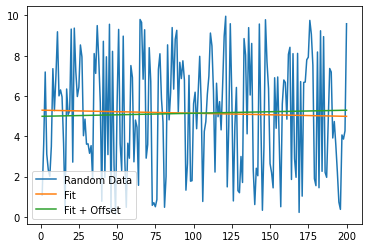

In [3]:
# Generate random data
x0 = range(1, size+1)
y0 = np.random.rand(size)*10

# Fit a linear curve to random data
popt,_ = curve_fit(objective,x0,y0)
y0_fit = objective(x0,popt[0],popt[1])

# Offset fit
popt_1, popt_2 = -popt[0]*0.99, y0_fit[-1]
y0_offset = objective(x0,popt_1,popt_2)

# plot figure
plt.plot(x0,y0,label='Random Data')
plt.plot(x0,y0_fit,label='Fit')
plt.plot(x0,y0_offset,label='Fit + Offset')
plt.legend();

### Residual sum of squares

In statistics, the residual sum of squares (RSS), also known as the sum of squared residuals (SSR) or the sum of squared estimate of errors (SSE), is the sum of the squares of residuals (deviations predicted from actual empirical values of data). It is a measure of the discrepancy between the data and an estimation model, such as a linear regression. A small RSS indicates a tight fit of the model to the data. It is used as an optimality criterion in parameter selection and model selection. [ https://en.wikipedia.org/wiki/Residual_sum_of_squares ]

In [4]:
print("Residual sum of squares (RSS). Lower is better.")

rss_list = (y0 - y0_fit)**2
rss = np.sum(rss_list)
print("RSS (optimal fit)", rss)

rss_list = (y0 - y0_offset)**2
rss = np.sum(rss_list)
print("RSS (offset fit)",rss)

Residual sum of squares (RSS). Lower is better.
RSS (optimal fit) 1631.3726137070557
RSS (offset fit) 1637.5845749166995


*RSS (optimal fit)* is the clear better fit.

### Example: Linear Fit

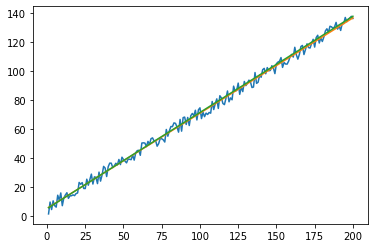

In [5]:
# Generate data
x1 = range(1,size+1)
y1 = objective(x1,np.random.rand(1),np.random.rand(1)) + np.random.rand(len(x1))*10

# Fit a linear curve to data
popt,_ = curve_fit(objective,x1,y1)
y1_fit = objective(x1,popt[0],popt[1])

# Offset fit
popt_1, popt_2 = popt[0]*1.01, y0_fit[0]*0.99
y1_offset = objective(x0,popt_1,popt_2)

# plot figure
plt.plot(x1,y1)
plt.plot(x1,y1_fit)
plt.plot(x1,y1_offset)

### Residual sum of squares

In [6]:
print("Residual sum of squares (RSS). Lower is better.")

rss_list = (y1 - y1_fit)**2
rss = np.sum(rss_list)
print("RSS (optimal fit)", rss)

rss_list = (y1 - y1_offset)**2
rss = np.sum(rss_list)
print("RSS (offset fit)",rss)

Residual sum of squares (RSS). Lower is better.
RSS (optimal fit) 1618.8035639980867
RSS (offset fit) 1695.2185243740382


*RSS (optimal fit)* is the clear better fit.

In these simple *Example: Random Data* and *Example: Linear Fit*, the best fit between 2 visually indistinctive fits is clear as existing goodness of fit criteria does a good job at identifying the best fit.

*to-do: add other verification of goodness of fit than RSS*

## Failure of Error and Residuals to describe natural truth

### A Less Simple Example: Univariate quadratic function

In [7]:
def objective(x, a, b, c):
    """
    Objective function to generate random data and to fit to
    """
    x2 = np.array([i**2 for i in x])
    y = a * x2 + b * x + c # Univariate quadratic function
    return y

In [8]:
# Data Creation
x2 = range(1,size+1)
y2 = objective(x2,np.random.rand(1),np.random.rand(1),np.random.rand(1)) + np.random.rand(len(x2))*100

In [9]:
# Optimal Fit
popt,_ = curve_fit(objective,x2,y2)
y2_fit = objective(x2,popt[0],popt[1],popt[2])

In [10]:
# # Offset
# popt[0],popt[1],popt[2] = popt[0]*1.001,popt[1]*0.999,popt[2]*1.001
# y2_offset = objective(x2,popt[0],popt[1],popt[2])

In [11]:
# Kink Introduction
rss_fit = 0
rss_kink = 1
while rss_kink > rss_fit: # make sure rss kink < rss optimal fit to illustrate point
    amount = 2 # number of kinks
    positions = [0, 0]
    while positions[0] == positions[1]:
        positions = [int(size*np.random.rand()) for i in range(amount)]
    print("kink positions = ",np.sort(positions))

    # negative offset, positive kinks
    y2_kink = [i*0.9999 for i in y2_fit]
    mean = np.mean(y2_fit)
    for i in positions:
        y2_kink[i] +=  np.random.rand()*mean*0.01
           
    rss_list = (y2 - y2_fit)**2
    rss_fit = np.sum(rss_list)
    rss_list = (y2 - y2_kink)**2
    rss_kink = np.sum(rss_list)


kink positions =  [119 190]
kink positions =  [ 70 114]
kink positions =  [ 9 53]
kink positions =  [ 75 142]
kink positions =  [ 47 192]
kink positions =  [100 140]
kink positions =  [ 34 136]
kink positions =  [112 130]
kink positions =  [119 156]
kink positions =  [ 57 108]
kink positions =  [ 78 163]
kink positions =  [ 46 189]


*to-do: make sure  kink always has lower rss than optimal*

*to-do: make kink more visible on graph, or zoom in to kink locations to show them better*

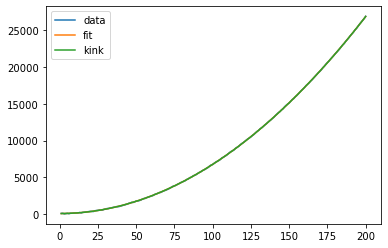

In [12]:
plt.plot(x2,y2,label='data')
plt.plot(x2,y2_fit,label='fit')
# plt.plot(x2,y2_offset,label='offset')
plt.plot(x2,y2_kink,label='kink')
plt.legend()

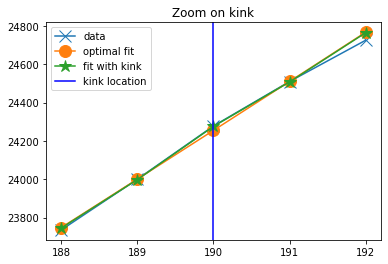

In [13]:
index0 = positions[1]-2;
index1 = positions[1]+3;

plt.plot(x2[index0:index1],y2[index0:index1],marker='x',markersize=12,label='data')
plt.plot(x2[index0:index1],y2_fit[index0:index1],marker='o',markersize=12,label='optimal fit')
# plt.plot(x2,y2_offset,label='offset')
plt.plot(x2[index0:index1],y2_kink[index0:index1],marker='*',markersize=12,label='fit with kink')
plt.axvline(x = positions[1]+1, color = 'b',label='kink location')
plt.xticks(np.arange(index0+1, index1+1, 1))
plt.title("Zoom on kink")
plt.legend()

In [14]:
rss_list = (y2 - y2_fit)**2
rss = np.sum(rss_list)
print("rss (fit)", rss)

# rss_list = (y2 - y2_offset)**2
# rss = np.sum(rss_list)
# print("rss (offset)",rss)

rss_list = (y2 - y2_kink)**2
rss = np.sum(rss_list)
print("rss (kink)",rss)

rss (fit) 178761.24969969515
rss (kink) 178406.24695570598


rss (kink) is lower than rss (fit)! Mathematically speaking the fit with the kink is the better fit, but naturally speaking the fit with kinks deviate from normal behaviour at the kink locations. Some kinks are minute enough to be ignored, but not all of them, for example for a system of molecules in interaction, a significant negative kink can introduce an energy minimum where none exists.

*to-do: find real example of a fit to illustrate this point better*

*in some cases "offset" might be more desirable for scientific reasons than the one presenting a kink*

*to-do: add example*

*to-do: here, kink is introduced by the user, but need to show at least 1 case of occurence of non user-generated kink*

# Proposed Solution

# Introduction of SODQ and Curvature (Menger)

[ https://en.wikipedia.org/wiki/Difference_quotient ]

In single-variable calculus, the **difference quotient** is usually the name for the expression

$${\displaystyle {\frac {f(x+h)-f(x)}{h}}}$$

which when taken to the limit as h approaches 0 gives the derivative of the function f.

By a slight change in notation (and viewpoint), for an interval [a, b], the difference quotient

$${\displaystyle {\frac {f(b)-f(a)}{b-a}}}$$

is called the mean (or average) value of the derivative of f over the interval [a, b].

[ https://en.wikipedia.org/wiki/Difference_quotient ]

*to-do: more details and published reference*

---

[ https://en.wikipedia.org/wiki/Menger_curvature ]

In mathematics, the **Menger curvature** of a triple of points in n-dimensional Euclidean space $R^n$ is the reciprocal of the radius of the circle that passes through the three points.

Let x, y and z be three points in Rn; for simplicity, assume for the moment that all three points are distinct and do not lie on a single straight line. Let Π ⊆ Rn be the Euclidean plane spanned by x, y and z and let C ⊆ Π be the unique Euclidean circle in Π that passes through x, y and z (the circumcircle of x, y and z). Let R be the radius of C. Then the Menger curvature c(x, y, z) of x, y and z is defined by

$${\displaystyle c(x,y,z)={\frac {1}{R}}}$$

If the three points are collinear, R can be informally considered to be +∞, and it makes rigorous sense to define c(x, y, z) = 0. If any of the points x, y and z are coincident, again define c(x, y, z) = 0.

Using the well-known formula relating the side lengths of a triangle to its area, it follows that

$${\displaystyle c(x,y,z)={\frac {1}{R}}={\frac {4A}{|x-y||y-z||z-x|}}}$$

where A denotes the area of the triangle spanned by x, y and z.

[ https://en.wikipedia.org/wiki/Menger_curvature ]

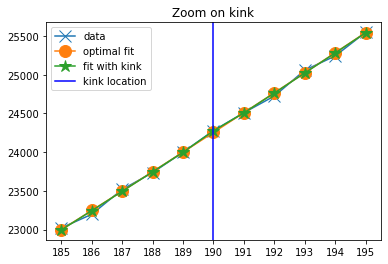

In [15]:
index0 = positions[1]-5;
index1 = positions[1]+6;

plt.plot(x2[index0:index1],y2[index0:index1],marker='x',markersize=12,label='data')
plt.plot(x2[index0:index1],y2_fit[index0:index1],marker='o',markersize=12,label='optimal fit')
# plt.plot(x2,y2_offset,label='offset')
plt.plot(x2[index0:index1],y2_kink[index0:index1],marker='*',markersize=12,label='fit with kink')
plt.axvline(x = positions[1]+1, color = 'b',label='kink location')
plt.xticks(np.arange(index0+1, index1+1, 1))
plt.title("Zoom on kink")
plt.legend()

*insignificant note:* In above figure it is difficult to see presence of kink visually.

*to-do: add example where kink is present around the minimum point of the energy of a  system and explain the scientific problems associated with a wrong energetic minimum*

*to-do: make below plot difference quotient and menger curvature and calculation more readable*

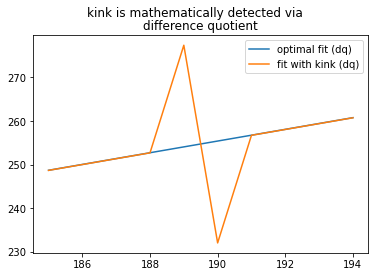

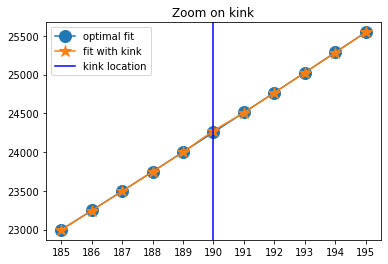

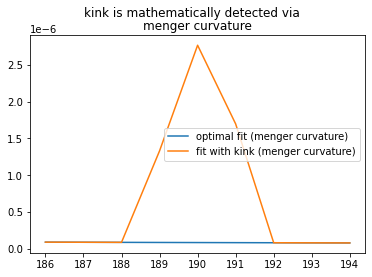

In [16]:
# difference_quotient
plt.figure(1)
# dq_data = [y2[i+1]-y2[i] for i in range(i0,i1-1)]
# plt.plot(dq_data, label="data")
dq_fit = [(y2_fit[i+1]-y2_fit[i])/((x2[i+1]-x2[i])) for i in range(index0,index1-1)]
plt.plot(x2[index0:index1-1], dq_fit, label="optimal fit (dq)")
dq_kink = [(y2_kink[i+1]-y2_kink[i])/((x2[i+1]-x2[i])) for i in range(index0,index1-1)]
plt.plot(x2[index0:index1-1], dq_kink, label="fit with kink (dq)")
plt.legend()
plt.title("difference quotient")
plt.suptitle("kink is mathematically detected via");

plt.figure(2)
plt.plot(x2[index0:index1],y2_fit[index0:index1],marker='o',markersize=12,label='optimal fit')
plt.plot(x2[index0:index1],y2_kink[index0:index1],marker='*',markersize=12,label='fit with kink')
plt.axvline(x = positions[1]+1, color = 'b',label='kink location')
plt.xticks(np.arange(index0+1, index1+1, 1))
plt.title("Zoom on kink")
plt.legend()

#curvature_menger
menger_fit = []
for i in range(index0+1,index1-1):
    x = np.array([[x2[i-1]],
                 [y2_fit[i-1]]])
    y = np.array([[x2[i]],
                 [y2_fit[i]]])
    z = np.array([[x2[i+1]],
                 [y2_fit[i+1]]])
    
    # area (A) of triangle in coordinate geometry
    # (1/2) |x1(y2 − y3) + x2(y3 − y1) + x3(y1 − y2)|
    A = 0.5 * np.abs(x[0]*(y[1]-z[1]) + y[0]*(z[1]-x[1]) + z[0]*(x[1]-y[1]))
    
    # vector L2-norm 
    tmp = x-y
    denominator0 = np.sqrt(tmp[0]**2 + tmp[1]**2)
    tmp = y-z
    denominator1 = np.sqrt(tmp[0]**2 + tmp[1]**2)
    tmp = z-x
    denominator2 = np.sqrt(tmp[0]**2 + tmp[1]**2)
    
    menger_fit.append((4*A)/(denominator0*denominator1*denominator2))

menger_kink = []
for i in range(index0+1,index1-1):
    x = np.array([[x2[i-1]],
                 [y2_kink[i-1]]])
    y = np.array([[x2[i]],
                 [y2_kink[i]]])
    z = np.array([[x2[i+1]],
                 [y2_kink[i+1]]])
    
    # area (A) of triangle in coordinate geometry
    # (1/2) |x1(y2 − y3) + x2(y3 − y1) + x3(y1 − y2)|
    A = 0.5 * np.abs(x[0]*(y[1]-z[1]) + y[0]*(z[1]-x[1]) + z[0]*(x[1]-y[1]))
    
    # vector L2-norm 
    tmp = x-y
    denominator0 = np.sqrt(tmp[0]**2 + tmp[1]**2)
    tmp = y-z
    denominator1 = np.sqrt(tmp[0]**2 + tmp[1]**2)
    tmp = z-x
    denominator2 = np.sqrt(tmp[0]**2 + tmp[1]**2)
    
    menger_kink.append((4*A)/(denominator0*denominator1*denominator2))
    
plt.figure(3)

plt.plot(x2[index0+1:index1-1], menger_fit, label="optimal fit (menger curvature)")

plt.plot(x2[index0+1:index1-1], menger_kink, label="fit with kink (menger curvature)")
plt.legend()
plt.title("menger curvature")
plt.suptitle("kink is mathematically detected via");

*to-do: align plots x-axis on plots*

*to-do: seriously..., make menger_curvature function!*

*to-do: is there numerical unstability on curvature with this code implementation? or was it just a bug once?*

The difference of dq and curvature of kink compared to optimal fit shows the presence of kinks. In this example the kink was visually very difficult to see, but more practical applications will present more visible kinks compared to this theoretical exercise.

For example if 2 curve fits were to present a kink at the same position, the one having lower menger curvature would represent a better fit in terms of shape of fit.

### Simple application example

### Theoretical exercise

Let there be 3 independent curves.

Create data set from 3 curves.

Fit 2 equations to all 3 data sets using shared variables between new equations.

In [17]:
# Create 3 data sets (from determined curves) with different but similar
# simple equations (preferably showing minima mimicking energy mimina)

In [18]:
# Fit multiple (more) complex equations to all 3

In [19]:
# Show how the closer the fit is to optimal,
# the lower the difference of the sum of Difference Quotient and Merger curvature is

In [20]:
# find a combination of equations that can present kinks and show detection of kink

## Practical use case

*2d spline?*

*what is used to detect Runge's phenomenon in splines? could be alternate generic application example that's simpler to show than ReaxFF one*

let there be n data sets. Let there be m equations with x number of variables.

2 fits are made via 2 different methods.

As difference of difference quotient | menger curvature between fit and optimal solution tends to 0, fit approaches  optimal solution/reference curve.

*to-do: find existing theorems*
*to-do: failing first to-do, mathematical proof and complete t body*